# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

Setting the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [4]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [5]:
class ModelBuilder(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20, smart_pick=False):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        self.smart_pick=smart_pick
        
        
    def generator(self,source_path, folder_list, augment=False):
        if self.smart_pick: # Leave 5 images from both the sides and pick mentioned images from the middle
            img_idx = np.round(np.linspace(5,24,self.frames_to_sample)).astype(int)
        else:
            img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
            
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [6]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25, batch_norm=True):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout))
            
        model.add(Dense(dense_neurons,activation='relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [7]:
project_folder='Project_data'

In [8]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=160,image_width=160)
conv_3d_test.initialize_hyperparams(frames_to_sample=30,batch_size=50,num_epochs=1)
conv_3d_test_model=conv_3d_test.define_model()
conv_3d_test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

In [9]:
#conv_3d_test.train_model(conv_3d_test_model)
#Above line is commented to avoid the error coming

### The input dimension [50(batch size),16(no. of filters),30(sequence length),160,160(image size)] is not a feasible one as it encountering `ResourceExhaustedError`

### Since the above dimension failed to load, various values all these parameters will have to be tried to check the training time

## Parameters that can be tuned
- Image size
- Frames to sample
- batch size

In [10]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=160,image_width=160)
conv_3d_test.initialize_hyperparams(frames_to_sample=16,batch_size=50,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 80, 80, 32)     128       
__________

In [11]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=160,image_width=160)
conv_3d_test.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 80, 80, 32)    128       
__________

In [12]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=100,image_width=100)
conv_3d_test.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 50, 50, 32)    128       
__________

In [13]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=100,image_width=100)
conv_3d_test.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_18 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 50, 50, 32)     128       
__________

In [14]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=100,image_width=100)
conv_3d_test.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_22 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 8, 50, 50, 32)     128       
__________

In [15]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=160,image_width=160)
conv_3d_test.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_26 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 80, 80, 32)     128       
__________

In [16]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=100,image_width=100)
conv_3d_test.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_30 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 15, 50, 50, 32)    128       
__________

In [17]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=160,image_width=160)
conv_3d_test.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 8, 80, 80, 32)     128       
__________

In [18]:
conv_3d_test=ModelConv3D()
conv_3d_test.initialize_path(project_folder)
conv_3d_test.initialize_image_properties(image_height=100,image_width=100)
conv_3d_test.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d_test_model=conv_3d_test.define_model()
print(conv_3d_test_model.summary())
conv_3d_test.train_model(conv_3d_test_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_38 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 8, 50, 50, 32)     128       
__________

## Inferences
- From the above experiments, it is clear that sequence length and the image size having greater impact on training time than the batch size
- Varying the batchsize is not impacting the training time. 
- Focus would be on varying the image size and sequence length

## Model 1
- No Batch norm, no augmentation, image size = 100, sequence length=30, batch size=20

In [19]:
conv_3d_1=ModelConv3D()
conv_3d_1.initialize_path(project_folder)
conv_3d_1.initialize_image_properties(image_height=100,image_width=100)
conv_3d_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d_model1=conv_3d_1.define_model(batch_norm=False)
conv_3d_model1.summary()
print("Total Params:", conv_3d_model1.count_params())
history_3dconv_model1=conv_3d_1.train_model(conv_3d_model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_42 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
max_pooling3d_42 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 7, 25, 25, 64)     55360     
__________

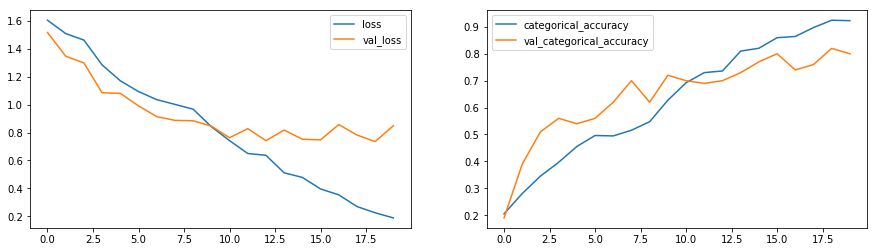

In [20]:
plot(history_3dconv_model1)

- Since BatchNorm is not used, learning curve is quite linear with epochs

## Model 2
- Parameters same as Model 1 except Batch Norm is enabled

In [21]:
conv_3d_2=ModelConv3D()
conv_3d_2.initialize_path(project_folder)
conv_3d_2.initialize_image_properties(image_height=100,image_width=100)
conv_3d_2.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d_model2=conv_3d_2.define_model()
print(conv_3d_model2.summary())
print("Total Params:", conv_3d_model2.count_params())
history_3dconv_model2=conv_3d_2.train_model(conv_3d_model2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_46 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 15, 50, 50, 32)    128       
__________

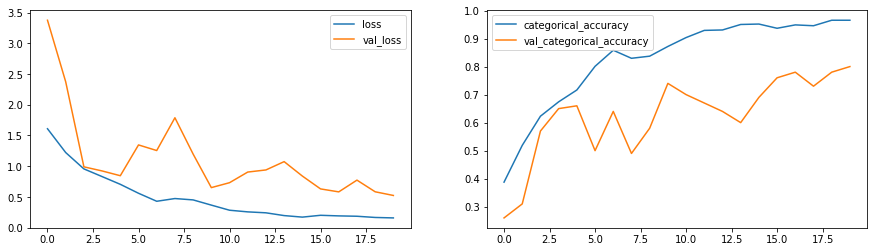

In [22]:
plot(history_3dconv_model2)

## Inference
- Since Batch norm has been enabled, learning curve is quite steep compared to Model 1
- Noticable gap between training abd validation accuracy seen

## Model 3
- Reducing the Image size and sequence length further to see if this helps in generalising the model and closing the gap between training and validation
- sequence length = 24, image size = 80, batch size 20

In [23]:
conv_3d_3=ModelConv3D()
conv_3d_3.initialize_path(project_folder)
conv_3d_3.initialize_image_properties(image_height=80,image_width=80)
conv_3d_3.initialize_hyperparams(frames_to_sample=24,batch_size=20,num_epochs=20)
conv_3d_model3=conv_3d_3.define_model()
print(conv_3d_model3.summary())
print("Total Params:", conv_3d_model3.count_params())
history_3dconv_model3=conv_3d_3.train_model(conv_3d_model3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 24, 80, 80, 16)    1312      
_________________________________________________________________
activation_49 (Activation)   (None, 24, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 24, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 12, 40, 40, 16)    0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 12, 40, 40, 32)    13856     
_________________________________________________________________
activation_50 (Activation)   (None, 12, 40, 40, 32)    0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 12, 40, 40, 32)    128       
__________

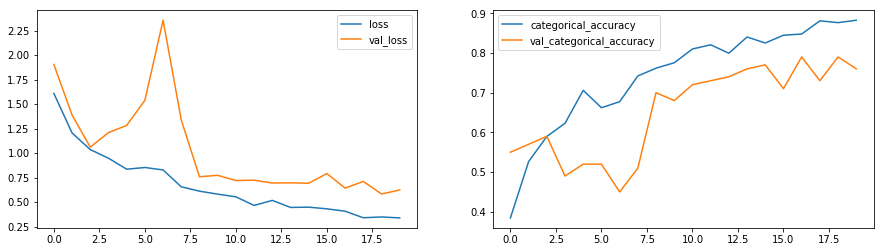

In [24]:
plot(history_3dconv_model3)

## Inference
- Reduced image size and sequence length gives out more or less similar results as model 2

# Model 4
- Since Model 3 was not quite better than Model 2 for generalising, Reducing sequence length to 16, image size as 100
- Augmentation has been enabled to see if this helps in training

In [25]:
conv_3d_4=ModelConv3D()
conv_3d_4.initialize_path(project_folder)
conv_3d_4.initialize_image_properties(image_height=100,image_width=100)
conv_3d_4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d_model4=conv_3d_4.define_model()
print(conv_3d_model4.summary())
print("Total Params:", conv_3d_model4.count_params())
history_3dconv_model4=conv_3d_4.train_model(conv_3d_model4, augment_data=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_54 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 8, 50, 50, 32)     128       
__________

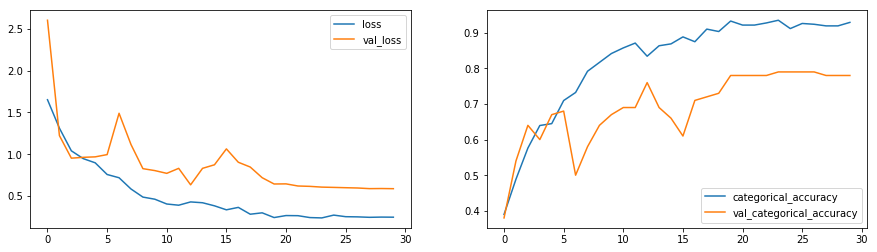

In [26]:
plot(history_3dconv_model4)

## Inference
- Similar results to Model 3 but training curve stabilised around 20 epochs

# Model 5
- Since only by reducing the image size and sequence did not help much, trying to reduce the filter size
- Reducing the filter size from 3\*3\*3 to 2\*2\*2
- Image size = 120, drop outs increased to 0.5 to help in getting a more generelisable model

In [27]:
conv_3d_5=ModelConv3D()
conv_3d_5.initialize_path(project_folder)
conv_3d_5.initialize_image_properties(image_height=120,image_width=120)
conv_3d_5.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d_model5=conv_3d_5.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
print(conv_3d_model5.summary())
print("Total Params:", conv_3d_model5.count_params())
history_3dconv_model5=conv_3d_5.train_model(conv_3d_model5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_57 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_58 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 8, 60, 60, 32)     128       
__________

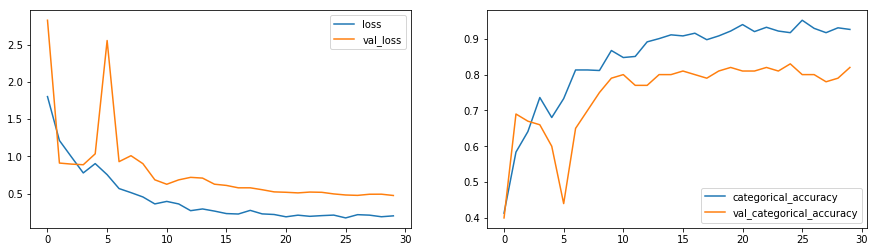

In [28]:
plot(history_3dconv_model5)

## Inference
- Validation accuracy improved considerably compared to previous models
- Reducing filter size and dropouts improves the validation accuracy

# Model 6
- Since Reduced filter size and more dropouts improves validation accuracy, with that same config, let us enable augmentation as well
- Augmentation should ideally help to learn better, lets see how this fares

In [29]:
conv_3d_6=ModelConv3D()
conv_3d_6.initialize_path(project_folder)
conv_3d_6.initialize_image_properties(image_height=100,image_width=100)
conv_3d_6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d_model6=conv_3d_6.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
print(conv_3d_model6.summary())
print("Total Params:", conv_3d_model6.count_params())
history_3dconv_model6=conv_3d_6.train_model(conv_3d_model6, augment_data=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 16, 100, 100, 16)  400       
_________________________________________________________________
activation_61 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_62 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 8, 50, 50, 32)     128       
__________

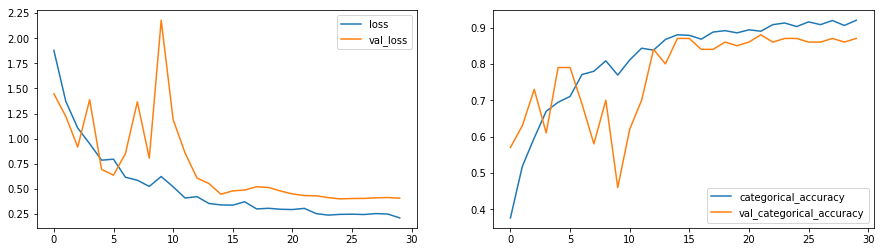

In [30]:
plot(history_3dconv_model6)

## Inference
- There are some oscillations seen in the plot. But since "ReduceLROnPlateau" has been set, LR has been acordingly changed(reduced)
- After epoch 10, LR has been reduced from default value of 0.001 to 0.002(approx)
- Post 19 epochs, LR has been further reduced to 0.00004(approx)
- Post 29 epochs, it has further reduced to 0.000008
- Good training and validation accuracy achieved, 92% and 87% respectively, good figures so far
- Only drawback is the number of parameters are 1.3 Million

# Model 7
- Now let us try different way of inputting images
- In the sequence of 30 images, first and the last few images may not be very useful in predicting the gesture compared to middle images
- Based on this, 5 images skipped at the beginning and 5 at the end and within the available middle image, those many number of images have been chosen which are configured by `frames_to_sample` variable
- This is being implemented by setting `smart_pick` variable to `True` in `initialize_hyperparams` call

In [31]:
# Use smart pick by leaving few at start, few at end and pick from inbetween, picking 16 middle images for modelling
conv_3d_7=ModelConv3D()
conv_3d_7.initialize_path(project_folder)
conv_3d_7.initialize_image_properties(image_height=120,image_width=120)
conv_3d_7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30,smart_pick=True)
conv_3d_model7=conv_3d_7.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
print(conv_3d_model7.summary())
print("Total Params:", conv_3d_model7.count_params())
history_3dconv_model7=conv_3d_7.train_model(conv_3d_model7, augment_data=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_65 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_66 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_92 (Batc (None, 8, 60, 60, 32)     128       
__________

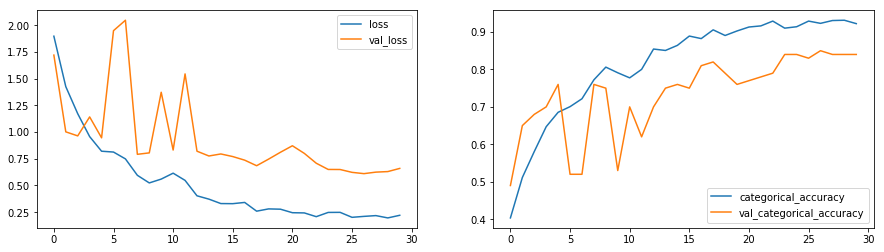

In [32]:
plot(history_3dconv_model7)

## Inference
- Good training and validation accuracies at 91% and 84% respectively
- But again this has 1.7 Million parameters

# Model 8
- Model 7 was with input image size of 120\*120 which is quite high
- Smart picking of images to form te sequence is enabled again
- Everything remains same as Model 7 but image size has been reduced to 80 to see if reduced to reduce the number of parameters to see the results

In [33]:
conv_3d_8=ModelConv3D()
conv_3d_8.initialize_path(project_folder)
conv_3d_8.initialize_image_properties(image_height=80,image_width=80)
conv_3d_8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30,smart_pick=True)
conv_3d_model8=conv_3d_8.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
print(conv_3d_model8.summary())
print("Total Params:", conv_3d_model8.count_params())
history_3dconv_model8=conv_3d_8.train_model(conv_3d_model8, augment_data=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 16, 80, 80, 16)    400       
_________________________________________________________________
activation_69 (Activation)   (None, 16, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 16, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 8, 40, 40, 16)     0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 8, 40, 40, 32)     4128      
_________________________________________________________________
activation_70 (Activation)   (None, 8, 40, 40, 32)     0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 8, 40, 40, 32)     128       
__________

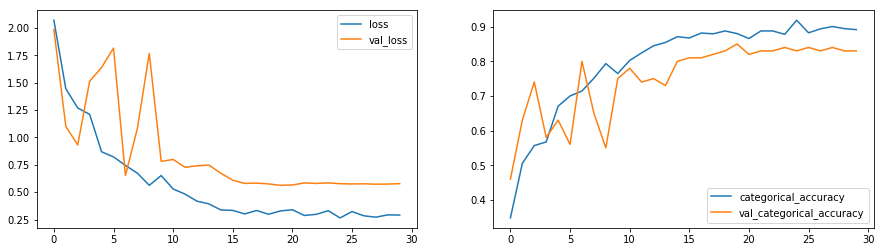

In [34]:
plot(history_3dconv_model8)

## Inference
- Though the training time and the number of parameters was lesser compared to Model 7, validation accuracy is more or less the same
- Training and Val accuracies are 91% and 83%  respectively

In [9]:
# Model with more layers
class ModelConv3D_MoreLayers(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25, batch_norm=True):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
            
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
            
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())


        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
            
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())


        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
            
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        if batch_norm:
            model.add(BatchNormalization())
            

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout))
            
        model.add(Dense(dense_neurons,activation='relu'))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 9
- Increasing the number of layers to see if that helps (Inferred from https://stats.stackexchange.com/questions/338255/what-is-effect-of-increasing-number-of-hidden-layers-in-a-feed-forward-nn#:~:text=1)%20Increasing%20the%20number%20of,you%20are%20trying%20to%20solve.&text=Where%20in%20the%20left%20picture,linear%20function%20to%20the%20data.)
- It could be the case that increasing the layers might help to achieve higher accuracy or it might overfit and fail to generalise
- Let us see what is the result by increasing the number of layers

In [10]:
conv_3d_9=ModelConv3D_MoreLayers()
conv_3d_9.initialize_path(project_folder)
conv_3d_9.initialize_image_properties(image_height=120,image_width=120)
conv_3d_9.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30,smart_pick=True)
conv_3d_model9=conv_3d_9.define_model(dense_neurons=256,dropout=0.5)
print(conv_3d_model9.summary())
print("Total Params:", conv_3d_model9.count_params())
history_3dconv_model9=conv_3d_9.train_model(conv_3d_model9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

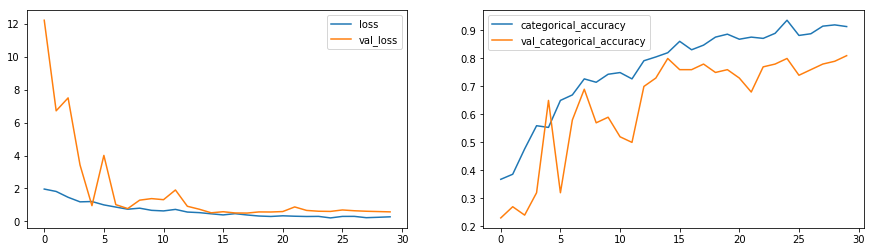

In [11]:
plot(history_3dconv_model9)

## Inference
- Increasing the number of layers with smart picking of sequences helped but did not change the results drastically.
- Validation accuracy is still pretty much the same
- On the flip side, the number of total parameters is around 2.5 Million which is huge

### So let us try to reduce the parameters and check the accuracies

In [12]:
# On the base model, let us try reducing the number of parameters
class ModelConv3D_ReducedParameters(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 10
- Since the number of parameters was around 2.5 Million when the layers were increased, it is not a preferred model with such high number of parameters
- So the number of parameters has been reduced in the next iteration to check the accuracies and ofcourse the number of parameters would be less compared to the previous one

In [13]:
conv_3d_10=ModelConv3D_ReducedParameters()
conv_3d_10.initialize_path(project_folder)
conv_3d_10.initialize_image_properties(image_height=120,image_width=120)
conv_3d_10.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30,smart_pick=True)
conv_3d_model10=conv_3d_10.define_model()
print(conv_3d_model10.summary())
print("Total Params:", conv_3d_model10.count_params())
history_3dconv_model10=conv_3d_10.train_model(conv_3d_model10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_14 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 60, 60, 32)     128       
__________

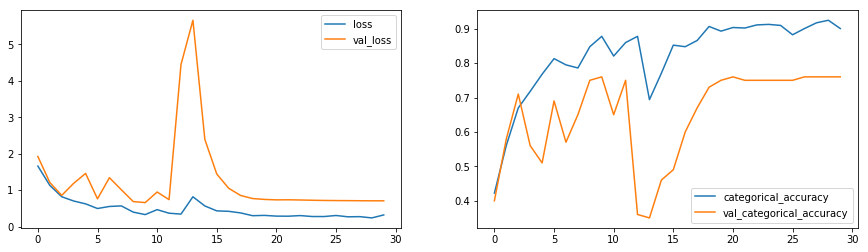

In [14]:
plot(history_3dconv_model10)

## Inference
- Training and validation accuracies are 94% and 86% respectively, still some gap seen between them
- Not the best but Pretty good preformance considering the number of trainable parameters

In [15]:
# Reducing the params further
class ModelConv3D_MoreReducedParameters(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))        
        
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 11
- Reducing the parameters further to see the effect of training and validation accuracies

In [16]:
conv_3d_11=ModelConv3D_MoreReducedParameters()
conv_3d_11.initialize_path(project_folder)
conv_3d_11.initialize_image_properties(image_height=120,image_width=120)
conv_3d_11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30,smart_pick=True)
conv_3d_model11=conv_3d_11.define_model()
print(conv_3d_model11.summary())
print("Total Params:", conv_3d_model11.count_params())
history_3dconv_model11=conv_3d_11.train_model(conv_3d_model11)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 60, 60, 16)     64        
__________

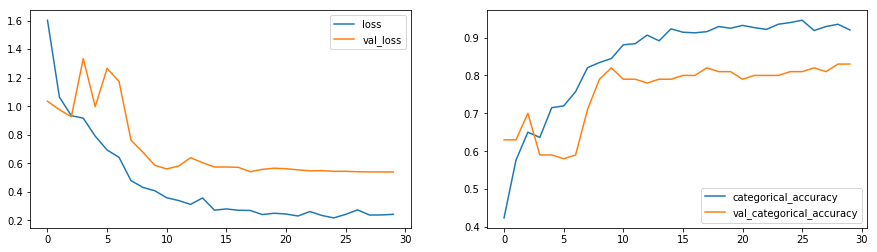

In [17]:
plot(history_3dconv_model11)

## Inference
- Training and validation accuracies are 93% and 83%
- This is acutally a very good result given the number of parameters are very less at 0.2 Million compared to previous models

# CNN2D-LSTM

In [9]:
class CNN2DLSTM(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 12
- CNN 2D with LSTM(for sequence)

In [10]:
conv_2d_lstm=CNN2DLSTM()
conv_2d_lstm.initialize_path(project_folder)
conv_2d_lstm.initialize_image_properties(image_height=120,image_width=120)
conv_2d_lstm.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30,smart_pick=True)
conv_2d_lstm_model=conv_2d_lstm.define_model(lstm_cells=64,dense_neurons=128,dropout=0.25)
conv_2d_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 30, 30, 64)    18496     
__________

In [11]:
print("Total Params:", conv_2d_lstm_model.count_params())
history_model12=conv_2d_lstm.train_model(conv_2d_lstm_model,augment_data=True)

Total Params: 1010021
Epoch 1/30
34/34 [==============================] - 186s 5s/step - loss: 1.4572 - categorical_accuracy: 0.3514 - val_loss: 1.4598 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-12-2304_35_49.247997/model-00001-1.46202-0.34766-1.45977-0.37000.h5
Epoch 2/30
34/34 [==============================] - 103s 3s/step - loss: 1.2220 - categorical_accuracy: 0.4993 - val_loss: 1.5256 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2020-12-2304_35_49.247997/model-00002-1.22342-0.49925-1.52557-0.34000.h5
Epoch 3/30
34/34 [==============================] - 105s 3s/step - loss: 1.1406 - categorical_accuracy: 0.5272 - val_loss: 1.1826 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2020-12-2304_35_49.247997/model-00003-1.13076-0.53620-1.18262-0.47000.h5
Epoch 4/30
34/34 [==============================] - 83s 2s/step - loss: 1.0164 - categorical_accuracy: 0.5769 - val_loss: 0.9875 - val_catego

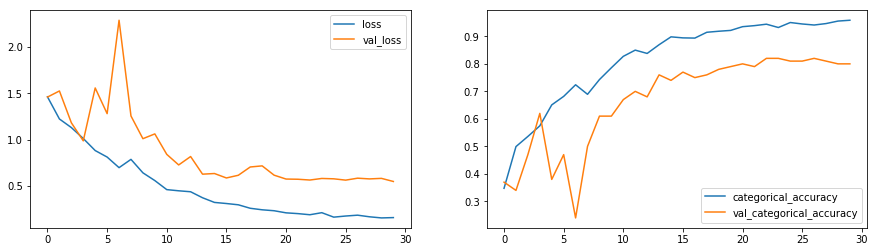

In [12]:
plot(history_model12)

## Inference
- validation accuracy is 80% compared to training accuracy of 95%
- Since LSTM are time consuming, number of LSTM cells are limited to 64
- Validation accuracy is not as good as fewer parmater models

# CNN2D with GRU

In [13]:
class CNN2DGRU(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 13
- CNN 2D with GRU instead of LSTM
- 128 GRU cells are used
- Smart picking of image sequences are used

In [14]:
conv_2d_gru=CNN2DGRU()
conv_2d_gru.initialize_path(project_folder)
conv_2d_gru.initialize_image_properties(image_height=120,image_width=120)
conv_2d_gru.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20,smart_pick=True)
conv_2d_gru_model=conv_2d_gru.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
conv_2d_gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 30, 30, 64)    18496     
__________

In [15]:
print("Total Params:", conv_2d_gru_model.count_params())
history_model13=conv_2d_gru.train_model(conv_2d_gru_model,augment_data=True)

Total Params: 1346021
Epoch 1/20
34/34 [==============================] - 85s 2s/step - loss: 1.4216 - categorical_accuracy: 0.3823 - val_loss: 1.2897 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-12-2305_19_06.413015/model-00001-1.43462-0.37104-1.28969-0.46000.h5
Epoch 2/20
34/34 [==============================] - 79s 2s/step - loss: 1.1182 - categorical_accuracy: 0.5482 - val_loss: 0.9901 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-12-2305_19_06.413015/model-00002-1.10595-0.55354-0.99009-0.66000.h5
Epoch 3/20
34/34 [==============================] - 81s 2s/step - loss: 0.9290 - categorical_accuracy: 0.6453 - val_loss: 1.0372 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-12-2305_19_06.413015/model-00003-0.93296-0.64480-1.03724-0.58000.h5
Epoch 4/20
34/34 [==============================] - 82s 2s/step - loss: 0.7726 - categorical_accuracy: 0.6968 - val_loss: 1.0202 - val_categoric

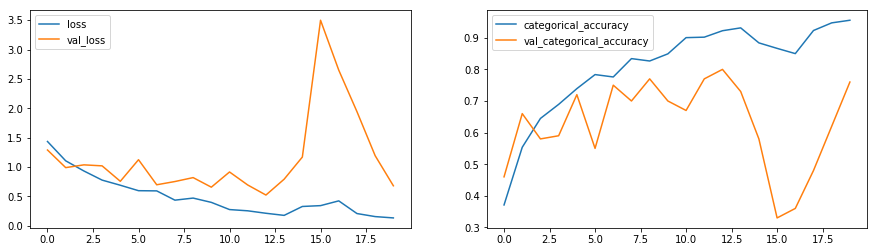

In [16]:
plot(history_model13)

## Inference
- Time taken per epoch is more or less the same as LSTM
- But we have to remember the fact that double the number of GRU cells are used compared to the number of LSTM cells in Model 12
- Still the time taken is similar because of the fact that GRU is simpler and having lesser parameters to train compared against LSTM
- Training accuracy is quite good at 92% but validation accuracy did not improve beyond 80%

# TL with Mobilenet with pretrained weights
- So far we have got the results for variants of Conv3D and CNNRNN models
- Both showed promising results, none of those models were too good interms of having both training and validation accuracies in the more than 90%
- Lets us try now Transfer Learning
- Mobilenet is used here for the following reasons
    - light weight deep neural networks best suited for mobile and embedded vision applications (problem statement is to deploy this model in smart TV)
    - Depthwise separable convolution is used to reduce the model size and complexity
    - uses two simple global hyperparameters that efficiently trades off between accuracy and latency
    - Small, low-latency convolutional neural network.
    - Reduced network size(17MB) and Reduced number of parameters(4.2 million) compared to state-of-the-art deep learning models
    - Faster in performance and are useful for mobile applications

In [17]:
from keras.applications import mobilenet

mobilenet_model_tl = mobilenet.MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 2s 0us/step


In [18]:
class TL_MOBILENET_GRU(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_model_tl,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 14
- Transfer Learning with Mobilenet architecture
- Model weights are frozen, GRU and dense layers are added

In [19]:
mobilenet_tl=TL_MOBILENET_GRU()
mobilenet_tl.initialize_path(project_folder)
mobilenet_tl.initialize_image_properties(image_height=120,image_width=120)
mobilenet_tl.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30, smart_pick=True)
mobilenet_tl_model=mobilenet_tl.define_model(lstm_cells=128,dense_neurons=128)
mobilenet_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
__________

In [20]:
print("Total Params:", mobilenet_tl_model.count_params())
history_model14=mobilenet_tl.train_model(mobilenet_tl_model,augment_data=True)

Total Params: 3692869
Epoch 1/30
34/34 [==============================] - 83s 2s/step - loss: 1.4750 - categorical_accuracy: 0.3716 - val_loss: 1.5397 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-12-2305_45_57.474349/model-00001-1.47015-0.37255-1.53972-0.33000.h5
Epoch 2/30
34/34 [==============================] - 73s 2s/step - loss: 0.8702 - categorical_accuracy: 0.6674 - val_loss: 1.1168 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-12-2305_45_57.474349/model-00002-0.88010-0.65913-1.11678-0.58000.h5
Epoch 3/30
34/34 [==============================] - 75s 2s/step - loss: 0.6340 - categorical_accuracy: 0.7597 - val_loss: 1.0633 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-12-2305_45_57.474349/model-00003-0.61852-0.76621-1.06330-0.56000.h5
Epoch 4/30
34/34 [==============================] - 74s 2s/step - loss: 0.4278 - categorical_accuracy: 0.8444 - val_loss: 1.7667 - val_categoric

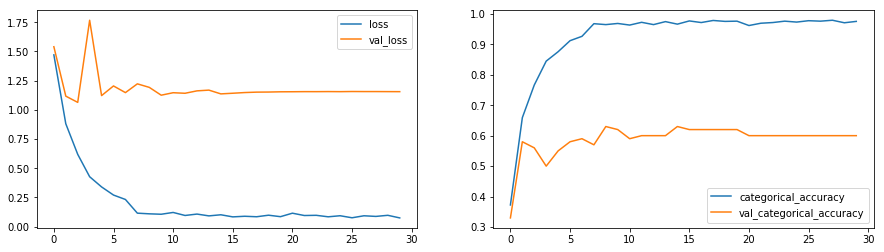

In [21]:
plot(history_model14)

## Inference
- With pretrained weights, the model is not able to learn generalisable features as it is overfitting quite heavily

# TL with Mobilenet and training all weights

In [22]:
class TL_MOBILENET_GRU_1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_model_tl,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

# Model 15
- Mobilenet with training all the weights

In [23]:
mobilenet_tl_1=TL_MOBILENET_GRU_1()
mobilenet_tl_1.initialize_path(project_folder)
mobilenet_tl_1.initialize_image_properties(image_height=100,image_width=100)
mobilenet_tl_1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=30, smart_pick=True)
mobilenet_tl_1_model=mobilenet_tl_1.define_model(lstm_cells=128,dense_neurons=128)
mobilenet_tl_1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_37 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_38 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_39 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
__________

In [24]:
print("Total Params:", mobilenet_tl_1_model.count_params())
history_model15=mobilenet_tl_1.train_model(mobilenet_tl_1_model,augment_data=True)

Total Params: 3692869
Epoch 1/30
67/67 [==============================] - 82s 1s/step - loss: 1.1535 - categorical_accuracy: 0.5296 - val_loss: 0.7051 - val_categorical_accuracy: 0.6800

Epoch 00001: saving model to model_init_2020-12-2306_23_16.210864/model-00001-1.13756-0.53167-0.70513-0.68000.h5
Epoch 2/30
67/67 [==============================] - 74s 1s/step - loss: 0.5424 - categorical_accuracy: 0.8010 - val_loss: 0.4159 - val_categorical_accuracy: 0.8400

Epoch 00002: saving model to model_init_2020-12-2306_23_16.210864/model-00002-0.53997-0.80241-0.41592-0.84000.h5
Epoch 3/30
67/67 [==============================] - 76s 1s/step - loss: 0.4165 - categorical_accuracy: 0.8590 - val_loss: 0.5980 - val_categorical_accuracy: 0.7900

Epoch 00003: saving model to model_init_2020-12-2306_23_16.210864/model-00003-0.40133-0.86275-0.59799-0.79000.h5
Epoch 4/30
67/67 [==============================] - 76s 1s/step - loss: 0.3184 - categorical_accuracy: 0.9010 - val_loss: 0.3916 - val_categoric

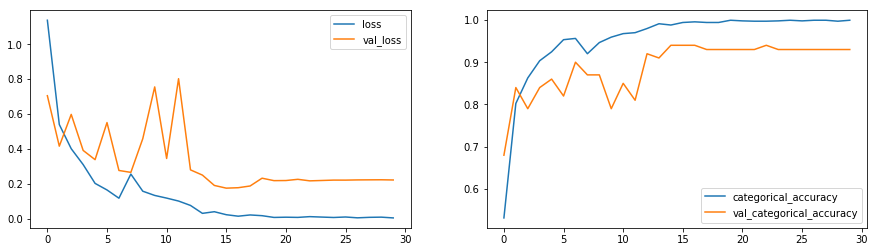

In [25]:
plot(history_model15)

## Inference
- By training the weights of mobilenet model, best result so far has been seen
- Training accuracy is 99% and Validation accuracy is 93%
- But the trainable parameters are around 3.6 Million which is quite humongous

# Conclusion
- The steps are summarized below
    - Initially Conv3D models have been tried by varying few aspects like below
        - Size of the input image
        - Number of images per sequence
        - Augmentation
        - Smart picking of images of a sequence
        - Increased layers in the model (More trainable parameters)
        - Reduced layers in the model (Less trainable parameters)
    - Conv2D with LSTM
    - Con2D with GRU
    - Transfer Learning for Images from Mobilenet with GRU and freesing the pre trained weights
    - Transfer Learning for Images from Mobilenet with GRU and training all the weights

- Though Transfer Learning with training all the weights is the best model in terms of accuracy, the size of trainable parameters are quite huge(3.6 Million)

- Model 10 above achieved very good validation accuracy of 86% with 0.5 Million parameters approx.
- Model 11 achieved almost same accuracy of 83% with 0.24 Million(less than half of what was used by Model 9)
    

# Model 11 with 83% validation accuracy with 0.24 Million trainable parameters is the chosen model for the given problem